In [ ]:
pip install gensim

In [ ]:
# import necessary packages
import pandas as pd
import numpy as np

import seaborn as sns

import nltk
from nltk.stem import PorterStemmer #for stemming
from nltk.tokenize import word_tokenize
import nltk.corpus

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn import svm
from xgboost import XGBClassifier
#from gensim.models.word2vec import Word2Vec

import matplotlib.pyplot as plt
import pickle

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# load all three datasets
trainFile = 'train2.tsv'
testFile = 'test2.tsv'
valFile = 'val2.tsv'

# add header to all three datasets
traindata = pd.read_csv(trainFile, delimiter='\t', encoding='utf-8', names=
                        ["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pants on fire", "los", "justification"])
traindata.name = 'Training Data'

testdata = pd.read_csv(testFile, delimiter='\t', encoding='utf-8', names=
                        ["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pants on fire", "los", "justification"])
testdata.name = 'Testing Data'

valdata = pd.read_csv(valFile, delimiter='\t', encoding='utf-8', names=
                        ["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pants on fire", "los", "justification"])
valdata.name = 'Validation Data'

In [ ]:
print(traindata.shape)
print(testdata.shape)
print(valdata.shape)

(10242, 15)
(1267, 15)
(1284, 15)


In [ ]:
traindata.head()

,json ID,label,statement,subject,speaker,job title,state,party,barely true,false,half true,mostly true,pants on fire,los,justification
0.0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1.0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2.0,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3.0,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4.0,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [ ]:
# function to get shape of each dataset
def cal_size(dataset):
  print(dataset.shape)

cal_size(traindata)
cal_size(valdata)
cal_size(testdata)

(10242, 15)
(1284, 15)
(1267, 15)


In [ ]:
testdata.head()

,json ID,label,statement,subject,speaker,job title,state,party,barely true,false,half true,mostly true,pants on fire,los,justification
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,"Meantime, engineering experts agree the wall w..."
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,She cited layoff notices received by the state...
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,"Trump said that McCain ""has done nothing to he..."
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,"But spending still goes up. In addition, many ..."
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video,Our rating A Democratic Party web video making...


In [ ]:
# function to check distribution of labels
def check_dist(dataset):
  sns.countplot(x='label', data=traindata, palette='hls')

In [ ]:
asd = pd.DataFrame(traindata['label'])

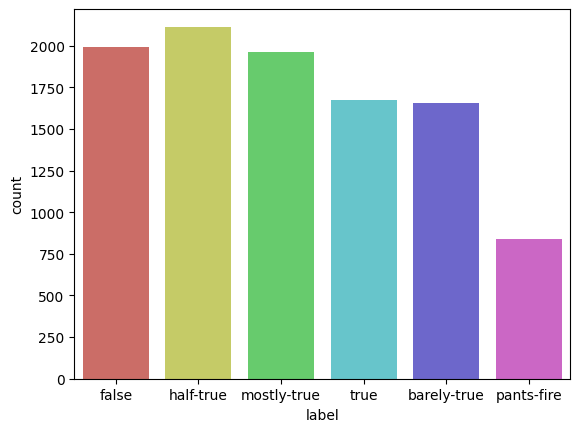

In [ ]:
check_dist(traindata)

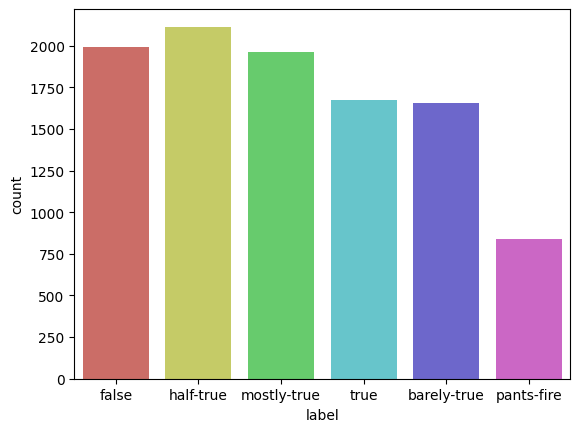

In [ ]:
check_dist(valdata)

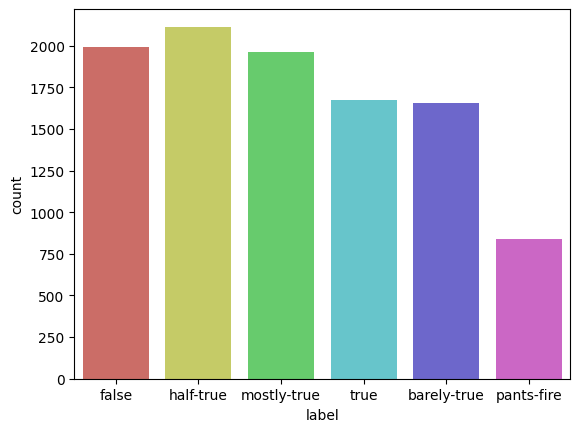

In [ ]:
check_dist(testdata)

In [ ]:
# check for missing labels
def check_missLabel(dataset):
#   dataset.info()
  print("Missing label values in {} are {}".format(dataset.name,dataset['label'].isnull().sum()))
  print("----------------------------------------------------------------")
check_missLabel(traindata)
check_missLabel(valdata)
check_missLabel(testdata)

Missing label values in Training Data are 2
----------------------------------------------------------------
Missing label values in Validation Data are 0
----------------------------------------------------------------
Missing label values in Testing Data are 0
----------------------------------------------------------------


In [ ]:
# concatenate validation data with training data
traindata_comb = pd.concat([traindata, valdata], axis=0)

In [ ]:
traindata = traindata_comb

In [ ]:
traindata.shape

(11526, 15)

In [ ]:
# merge 'statement' and 'justification' columns
traindata['new'] = traindata['statement'].map(str) + traindata['justification'].map(str)
# testdata['new'] = testdata['statement'].map(str) + testdata['justification'].map(str)

In [ ]:
traindata['new'].iloc[0:1].values

array(["Says the Annies List political group supports third-trimester abortions on demand.That's a premise that he fails to back up. Annie's List makes no bones about being comfortable with candidates who oppose further restrictions on late-term abortions. Then again, this year its backing two House candidates who voted for more limits."],
      dtype=object)

In [ ]:
traindata.isnull().sum()

,0
json ID,2
label,2
statement,2
subject,4
speaker,4
job title,3245
state,2491
party,4
barely true,4
false,4


In [ ]:
# Removing rows with null values
traindata.dropna(inplace = True)

In [ ]:
print(traindata.shape)
traindata.isnull().sum()

(7524, 16)


,0
json ID,0
label,0
statement,0
subject,0
speaker,0
job title,0
state,0
party,0
barely true,0
false,0


**Feature extraction (vectorization) :**Pre-processing 1: **Build Bag-Of-Words model using CountVectorizer + TfidfVectorizer.**






In [ ]:
# Convert text to word count vectors with CountVectorizer
# create the transform
cvec = CountVectorizer()

# tokenize, build vocab and encode training data
traindata_cvec = cvec.fit_transform(traindata['new'].values)

# summarize
print(cvec.vocabulary_)
# print(cvec.get_feature_names())

{'says': 17416, 'the': 19800, 'annies': 1793, 'list': 11824, 'political': 15100, 'group': 9115, 'supports': 19299, 'third': 19881, 'trimester': 20339, 'abortions': 1039, 'on': 13907, 'demand': 5798, 'that': 19770, 'premise': 15357, 'he': 9435, 'fails': 7704, 'to': 20030, 'back': 2385, 'up': 20881, 'annie': 1792, 'makes': 12135, 'no': 13499, 'bones': 3058, 'about': 1042, 'being': 2690, 'comfortable': 4499, 'with': 21692, 'candidates': 3639, 'who': 21578, 'oppose': 13972, 'further': 8564, 'restrictions': 16798, 'late': 11450, 'term': 19704, 'then': 19831, 'again': 1417, 'this': 19885, 'year': 21891, 'its': 10799, 'backing': 2396, 'two': 20473, 'house': 9822, 'voted': 21243, 'for': 8256, 'more': 13036, 'limits': 11786, 'when': 21543, 'did': 6080, 'decline': 5658, 'of': 13794, 'coal': 4358, 'start': 18765, 'it': 10790, 'started': 18766, 'natural': 13294, 'gas': 8660, 'took': 20080, 'off': 13796, 'begin': 2671, 'in': 10141, 'president': 15395, 'george': 8749, 'bushs': 3478, 'administration'

says': 9676, 'the': 10988, 'annies': 1044, 'list': 6639, 'political': 8376,

In [ ]:
# summarize encoded vector
print(traindata_cvec.shape)
print(type(traindata_cvec))
print(traindata_cvec.toarray())

(7524, 21992)
<class 'scipy.sparse._csr.csr_matrix'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# Calculate inverse document frequencies
# create the transform
tfidf_vec = TfidfTransformer()

# tokenize, build vocab and encode training data
traindata_tfidf_vec = tfidf_vec.fit_transform(traindata_cvec)

In [ ]:
# tfidf score
tfidf_vec.transform(traindata_cvec)

<7524x21992 sparse matrix of type '<class 'numpy.float64'>'
	with 480654 stored elements in Compressed Sparse Row format>

In [ ]:
# summarize encoded vector
print(traindata_tfidf_vec.shape)
print(traindata_tfidf_vec.toarray())

(7524, 21992)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


**Task: Six-way classification**

**1. Model Building with Count Vectorizer + TFIDF Vectorizer**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Pipeline with CV + TF-IDF + Logistic Regression
logReg_pipeline = Pipeline([
    ('cv', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train model
logReg_pipeline.fit(traindata['new'], traindata['label'])

# Predictions
y_pred = logReg_pipeline.predict(testdata['statement'])
print("Accuracy:", accuracy_score(testdata['label'], y_pred))
print("\nClassification Report (Logistic Regression):\n", classification_report(testdata['label'], y_pred))


# ---------------- Support Vector Machine (SVM) ----------------
svm_pipeline = Pipeline([
    ('cv', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC())   # Linear kernel SVM for text classification
])

svm_pipeline.fit(traindata['new'], traindata['label'])
y_pred_svm = svm_pipeline.predict(testdata['statement'])
print("SVM Accuracy:", accuracy_score(testdata['label'], y_pred_svm))
print("\nClassification Report (SVM):\n", classification_report(testdata['label'], y_pred_svm))


# ---------------- Naive Bayes ----------------
nb_pipeline = Pipeline([
    ('cv', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())   # works well with word count / tf-idf data
])

nb_pipeline.fit(traindata['new'], traindata['label'])
y_pred_nb = nb_pipeline.predict(testdata['statement'])
print("Naive Bayes Accuracy:", accuracy_score(testdata['label'], y_pred_nb))
print("\nClassification Report (Naive Bayes):\n", classification_report(testdata['label'], y_pred_nb))


# ---------------- Random Forest ----------------
rf_pipeline = Pipeline([
    ('cv', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42))
])

rf_pipeline.fit(traindata['new'], traindata['label'])
y_pred_rf = rf_pipeline.predict(testdata['statement'])
print("Random Forest Accuracy:", accuracy_score(testdata['label'], y_pred_rf))
print("\nClassification Report (Random Forest):\n", classification_report(testdata['label'], y_pred_rf))


Accuracy: 0.23599052880820837

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

 barely-true       0.20      0.18      0.19       212
       false       0.22      0.37      0.27       249
   half-true       0.27      0.31      0.28       265
 mostly-true       0.25      0.17      0.20       241
  pants-fire       0.00      0.00      0.00        92
        true       0.26      0.22      0.23       208

    accuracy                           0.24      1267
   macro avg       0.20      0.21      0.20      1267
weighted avg       0.22      0.24      0.22      1267

SVM Accuracy: 0.21468034727703236

Classification Report (SVM):
               precision    recall  f1-score   support

 barely-true       0.21      0.21      0.21       212
       false       0.22      0.27      0.24       249
   half-true       0.24      0.24      0.24       265
 mostly-true       0.22      0.19      0.20       241
  pants-fire       0.07      0.04      0.05 

**Pre-processing 2: TFIDF with ngram**

> Add blockquote



In [ ]:
# tfidf + ngrams
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), use_idf=True, smooth_idf=True)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(traindata['new'].values)

In [ ]:
# print(tfidf_ngram.toarray())
# tfidf.vocabulary_
first_vector_tfidfvectorizer = tfidf_vectorizer_vectors[0]


# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names_out(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)


,tfidf
abortions,0.197851
candidates,0.175806
list,0.172545
bones,0.157944
demand premise,0.157944
...,...
face criticism,0.000000
face complaint,0.000000
face combine,0.000000
face census,0.000000


**2. Model Building with TF-IDF vectorizer with n-gram**


In [ ]:
# using LogisticRegression
logReg_pipeline_ngram = Pipeline([
    ('LogR_tfidf', tfidf_vectorizer),
    ('LogR_model', LogisticRegression())
])

logReg_pipeline_ngram.fit(traindata['new'], traindata['label'])
predictions_logReg_ngram = logReg_pipeline_ngram.predict(testdata['statement'])
logReg_ngram = np.mean(predictions_logReg_ngram == testdata['label'])

# using SVM
svm_pipeline_ngram = Pipeline([
    ('svmCV', tfidf_vectorizer),
    ('svm_model', svm.LinearSVC())
])

svm_pipeline_ngram.fit(traindata['new'], traindata['label'])
predictions_svm = svm_pipeline_ngram.predict(testdata['statement'])
svm_ngram = np.mean(predictions_svm == testdata['label'])

# using naive bayes
nb_pipeline_ngram = Pipeline([
    ('nbCV', tfidf_vectorizer),
    ('nb_model', MultinomialNB())
])

nb_pipeline_ngram.fit(traindata['new'], traindata['label'])
predictions_nb = nb_pipeline_ngram.predict(testdata['statement'])
nb_ngram = np.mean(predictions_nb == testdata['label'])

# using random forest
rf_pipeline_ngram = Pipeline([
    ('rfCV', tfidf_vectorizer),
    ('rf_model', RandomForestClassifier(n_estimators=400, n_jobs=4))
])

rf_pipeline_ngram.fit(traindata['new'], traindata['label'])
predictions_rf = rf_pipeline_ngram.predict(testdata['statement'])
rf_ngram = np.mean(predictions_rf == testdata['label'])

# using XGBoost
#xgb_pipeline_ngram = Pipeline([
#    ('xgbCV', tfidf_vectorizer),
#    ('xgb_model', XGBClassifier())
#])

#xgb_pipeline_ngram.fit(traindata['new'], y_train_xgb)
#predictions_xgb = xgb_pipeline_ngram.predict(testdata['statement'])
#xgb_ngram = np.mean(predictions_xgb == y_test_xgb)


In [ ]:
print(logReg_ngram)
print(svm_ngram)
print(nb_ngram)
print(rf_ngram)
#print(xgb_ngram)

0.23441199684293607
0.23362273086029992
0.22730860299921074
0.2249408050513023


In [ ]:
def kFoldCV(model):
  k_fold = KFold(n_splits=5)
  scores = []
  conf_matrix = np.zeros(shape=(6,6))

  for train_index, test_index in k_fold.split(traindata['new']):
    trainText = traindata.iloc[train_index]['new']
    train_y = traindata.iloc[train_index]['label']

    testText = traindata.iloc[test_index]['new']
    test_y = traindata.iloc[test_index]['label']

    model.fit(trainText, train_y)
    pred_y = model.predict(testText)

    conf_matrix += confusion_matrix(test_y, pred_y)
    scores.append(f1_score(test_y, pred_y, average='micro'))

  return (print('Total statements classified:', len(traindata)),
         print('Score:', sum(scores)/len(scores)),
         print('Confusion Matrix:'),
         print(conf_matrix),
         print("---------------------------------------------------"))

In [ ]:
kFoldCV(logReg_pipeline_ngram)
kFoldCV(svm_pipeline_ngram)
kFoldCV(nb_pipeline_ngram)
kFoldCV(rf_pipeline_ngram)
#kFoldCV(xgb_pipeline_ngram)

Total statements classified: 7524
Score: 0.21929870290520959
Confusion Matrix:
[[ 67. 273. 421. 342.   0.  91.]
 [ 73. 378. 470. 423.   0. 121.]
 [ 87. 337. 551. 478.   0. 120.]
 [ 52. 307. 519. 521.   0. 129.]
 [ 26. 133. 180. 127.   0.  29.]
 [ 40. 282. 392. 422.   0. 133.]]
---------------------------------------------------
Total statements classified: 7524
Score: 0.21305108857001484
Confusion Matrix:
[[159. 251. 304. 295.  15. 170.]
 [184. 338. 341. 359.  18. 225.]
 [187. 313. 425. 412.   7. 229.]
 [184. 283. 382. 443.  16. 220.]
 [ 63. 103. 146. 115.  11.  57.]
 [129. 250. 292. 359.  12. 227.]]
---------------------------------------------------
Total statements classified: 7524
Score: 0.22129223510284865
Confusion Matrix:
[[  0. 101. 739. 351.   0.   3.]
 [  1. 142. 878. 441.   0.   3.]
 [  2. 140. 966. 465.   0.   0.]
 [  0. 128. 846. 554.   0.   0.]
 [  0.  52. 317. 126.   0.   0.]
 [  1. 117. 724. 424.   0.   3.]]
---------------------------------------------------
Total stat

(None, None, None, None, None)

**3. Model Building with only Count Vectorizer**

In [ ]:
# using LogisticRegression
logReg_pipeline_cv = Pipeline([
    ('LogRCV', cvec),
    ('LogR_model', LogisticRegression())
])

logReg_pipeline_cv.fit(traindata['new'], traindata['label'])
predictions_logReg = logReg_pipeline_cv.predict(testdata['statement'])
logReg_cv = np.mean(predictions_logReg == testdata['label'])

# using SVM
svm_pipeline_cv = Pipeline([
    ('svmCV', cvec),
    ('svm_model', svm.LinearSVC())
])

svm_pipeline_cv.fit(traindata['new'], traindata['label'])
predictions_svm = svm_pipeline_cv.predict(testdata['statement'])
svm_cv = np.mean(predictions_svm == testdata['label'])

# using naive bayes
nb_pipeline_cv = Pipeline([
    ('nbCV', cvec),
    ('nb_model', MultinomialNB())
])

nb_pipeline_cv.fit(traindata['new'], traindata['label'])
predictions_nb = nb_pipeline_cv.predict(testdata['statement'])
nb_cv = np.mean(predictions_nb == testdata['label'])

# using random forest
rf_pipeline_cv = Pipeline([
    ('rfCV', cvec),
    ('rf_model', RandomForestClassifier(n_estimators=400, n_jobs=4))
])

rf_pipeline_cv.fit(traindata['new'], traindata['label'])
predictions_rf = rf_pipeline_cv.predict(testdata['statement'])
rf_cv = np.mean(predictions_rf == testdata['label'])


In [ ]:
print(logReg_cv)
print(svm_cv)
print(nb_cv)
print(rf_cv)

0.21941594317284924
0.20994475138121546
0.23046566692975531
0.21941594317284924


In [ ]:
kFoldCV(logReg_pipeline_cv)
kFoldCV(svm_pipeline_cv)
kFoldCV(nb_pipeline_cv)
kFoldCV(rf_pipeline_cv)
#kFoldCV(xgb_pipeline_cv)

Total statements classified: 7524
Score: 0.19923066727928182
Confusion Matrix:
[[197. 254. 281. 237.  45. 180.]
 [220. 335. 312. 300.  64. 234.]
 [257. 356. 350. 302.  60. 248.]
 [219. 325. 319. 361.  51. 253.]
 [ 69. 114. 127.  96.  31.  58.]
 [162. 280. 287. 268.  47. 225.]]
---------------------------------------------------
Total statements classified: 7524
Score: 0.19856435993496854
Confusion Matrix:
[[217. 220. 259. 255.  59. 184.]
 [223. 307. 309. 300.  68. 258.]
 [269. 303. 353. 322.  72. 254.]
 [234. 292. 322. 340.  70. 270.]
 [ 76.  94. 117. 100.  50.  58.]
 [172. 268. 278. 275.  49. 227.]]
---------------------------------------------------
Total statements classified: 7524
Score: 0.21291846327843356
Confusion Matrix:
[[101. 222. 477. 242.   0. 152.]
 [104. 290. 563. 301.   1. 206.]
 [108. 313. 644. 314.   0. 194.]
 [108. 265. 596. 384.   1. 174.]
 [ 38.  92. 225.  93.   0.  47.]
 [ 70. 236. 482. 298.   0. 183.]]
---------------------------------------------------
Total stat

(None, None, None, None, None)

**Task: Binary Classification**

In [ ]:
def classLabel(dataset):
    true_labels = ['true']
    false_labels = ['false']

    dataset['label'] = dataset['label'].apply(lambda x: 'true' if x in true_labels else 'false')
    return dataset

In [ ]:
new_train = classLabel(traindata)
new_test = classLabel(testdata)
new_val = classLabel(valdata)

In [ ]:
new_train['label'].unique()

array(['false', 'true'], dtype=object)

In [ ]:
new_train = new_train[['statement','label']]
new_test = new_test[['statement','label']]
new_val = new_val[['statement','label']]

In [ ]:
new_test.head()

,statement,label
0,Building a wall on the U.S.-Mexico border will...,true
1,Wisconsin is on pace to double the number of l...,false
2,Says John McCain has done nothing to help the ...,false
3,Suzanne Bonamici supports a plan that will cut...,false
4,When asked by a reporter whether hes at the ce...,false


In [ ]:
# concatenate validation set with training dataset
new_train1 = pd.concat([new_train, new_val], axis=0)
new_train = new_train1

# drop Null rows
new_train = new_train.dropna()

In [ ]:
new_train.head()

,statement,label
0.0,Says the Annies List political group supports ...,false
1.0,When did the decline of coal start? It started...,false
2.0,"Hillary Clinton agrees with John McCain ""by vo...",false
5.0,The Chicago Bears have had more starting quart...,true
7.0,I'm the only person on this stage who has work...,false


**Feature extraction (vectorization) :** Build Bag-Of-Words model using CountVectorizer and TfidfVectorizer.






In [ ]:
# Convert text to word count vectors with CountVectorizer
# create the transform
cvec = CountVectorizer()

# tokenize, build vocab and encode training data
traindata_cvec = cvec.fit_transform(new_train['statement'].values)

# summarize
print(cvec.vocabulary_)
# print(cvec.get_feature_names())

{'says': 8323, 'the': 9468, 'annies': 901, 'list': 5689, 'political': 7184, 'group': 4383, 'supports': 9222, 'third': 9502, 'trimester': 9728, 'abortions': 533, 'on': 6626, 'demand': 2825, 'when': 10281, 'did': 2955, 'decline': 2742, 'of': 6576, 'coal': 2122, 'start': 8979, 'it': 5183, 'started': 8980, 'natural': 6356, 'gas': 4169, 'took': 9596, 'off': 6578, 'that': 9459, 'to': 9572, 'begin': 1319, 'in': 4868, 'president': 7337, 'george': 4210, 'bushs': 1673, 'administration': 651, 'hillary': 4611, 'clinton': 2093, 'agrees': 742, 'with': 10362, 'john': 5253, 'mccain': 5975, 'by': 1692, 'voting': 10128, 'give': 4241, 'bush': 1671, 'benefit': 1353, 'doubt': 3156, 'iran': 5138, 'chicago': 1969, 'bears': 1294, 'have': 4512, 'had': 4431, 'more': 6234, 'starting': 8982, 'quarterbacks': 7588, 'last': 5498, '10': 17, 'years': 10451, 'than': 9452, 'total': 9612, 'number': 6512, 'tenured': 9417, 'uw': 9992, 'faculty': 3732, 'fired': 3908, 'during': 3248, 'two': 9801, 'decades': 2727, 'only': 663

In [ ]:
# Calculate inverse document frequencies
# create the transform
tfidf_vec = TfidfTransformer()

# tokenize, build vocab and encode training data
traindata_tfidf_vec = tfidf_vec.fit_transform(traindata_cvec)

In [ ]:
# tfidf score
tfidf_vec.transform(traindata_cvec)

<8808x10498 sparse matrix of type '<class 'numpy.float64'>'
	with 142577 stored elements in Compressed Sparse Row format>

**Count vectorizer + TFIDF:** The code is functionally equivalent to using CountVectorizer followed by TfidfTransformer.
CountVectorizer: Tokenizes the text into words (or n-grams), builds a vocabulary, and transforms the text into a document-term matrix of raw counts. For example, if you have 3 documents and a vocabulary of 5 words, you'll get a 3X5 sparse matrix where each entry is the word count.
TfidfTransformer: Takes that count matrix and reweights it using TF-IDF. Here, you can control whether to apply the inverse document frequency (use_idf=True or False) and normalization (L1/L2 norms).
So the flow is:
raw text → CountVectorizer (counts) → TfidfTransformer (TF-IDF weights)

In [ ]:
# tfidf + ngrams
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(new_train['statement'].values)

Encoding labels for XGBoost

In [ ]:
new_train_xgb = new_train
new_test_xgb = new_test

In [ ]:
new_train_xgb['label'].replace({'false': 0, 'true': 1}, inplace = True)
new_test_xgb['label'].replace({'false': 0, 'true': 1}, inplace = True)

In [ ]:
new_test_xgb.head()

,statement,label
0,Building a wall on the U.S.-Mexico border will...,1
1,Wisconsin is on pace to double the number of l...,0
2,Says John McCain has done nothing to help the ...,0
3,Suzanne Bonamici supports a plan that will cut...,0
4,When asked by a reporter whether hes at the ce...,0


**Model 1: Feature extraction: Count vectorizer**

In [ ]:
# using LogisticRegression
logReg_pipeline_cv = Pipeline([
    ('LogRCV', cvec),
    ('LogR_model', LogisticRegression())
])

logReg_pipeline_cv.fit(new_train['statement'], new_train['label'])
predictions_logReg = logReg_pipeline_cv.predict(new_test['statement'])
logReg_cv = np.mean(predictions_logReg == new_test['label'])

# using SVM
svm_pipeline_cv = Pipeline([
    ('svmCV', cvec),
    ('svm_model', svm.LinearSVC())
])

svm_pipeline_cv.fit(new_train['statement'], new_train['label'])
predictions_svm = svm_pipeline_cv.predict(new_test['statement'])
svm_cv = np.mean(predictions_svm == new_test['label'])

# using naive bayes
nb_pipeline_cv = Pipeline([
    ('nbCV', cvec),
    ('nb_model', MultinomialNB())
])

nb_pipeline_cv.fit(new_train['statement'], new_train['label'])
predictions_nb = nb_pipeline_cv.predict(new_test['statement'])
nb_cv = np.mean(predictions_nb == new_test['label'])

# using random forest
rf_pipeline_cv = Pipeline([
    ('rfCV', cvec),
    ('rf_model', RandomForestClassifier(n_estimators=400, n_jobs=4))
])

rf_pipeline_cv.fit(new_train['statement'], new_train['label'])
predictions_rf = rf_pipeline_cv.predict(new_test['statement'])
rf_cv = np.mean(predictions_rf == new_test['label'])

# using XGBoost
xgb_pipeline_cv = Pipeline([
    ('xgbCV', cvec),
    ('xgb_model', xgb.XGBClassifier())
])

#X_train_text = new_train_xgb['statement']  # Must be text
#X_test_text = new_test_xgb['statement']    # Must be text


# Vectorize text data
#X_train_vec = cvec.fit_transform(X_train_text)
#X_test_vec = cvec.transform(X_test_text)

# Apply SMOte
#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X_train_vec, new_train_xgb['label'])

#xgb_pipeline_cv.fit(X_resampled, y_resampled)

xgb_pipeline_cv.fit(new_train_xgb['statement'], new_train_xgb['label'])
predictions_xgb = xgb_pipeline_cv.predict(new_test_xgb['statement'])
xgb_cv = np.mean(predictions_xgb == new_test_xgb['label'])


In [ ]:
print(logReg_cv)
print(svm_cv)
print(nb_cv)
print(rf_cv)
print(xgb_cv)
# new_predictions_logReg

0.8066298342541437
0.739542225730071
0.8184688239936859
0.8342541436464088
0.824782951854775


In [ ]:
new_train['label'].value_counts()

,count
label,
0,7370
1,1438


**Model 2: Feature extraction: Count vectorizer + TF-IDF vectorizer**

In [ ]:
# using LogisticRegression
logReg_pipeline_cv = Pipeline([
    ('LogRCV', tfidf_vectorizer),
    ('LogR_model', LogisticRegression(random_state=42))
])

logReg_pipeline_cv.fit(new_train['statement'], new_train['label'])
predictions_logReg = logReg_pipeline_cv.predict(new_test['statement'])
logReg_ngram = np.mean(predictions_logReg == new_test['label'])

# using SVM
svm_pipeline_cv = Pipeline([
    ('svmCV', tfidf_vectorizer),
    ('svm_model', svm.LinearSVC(random_state=42))
])

svm_pipeline_cv.fit(new_train['statement'], new_train['label'])
predictions_svm = svm_pipeline_cv.predict(new_test['statement'])
svm_ngram = np.mean(predictions_svm == new_test['label'])

# using naive bayes
nb_pipeline_cv = Pipeline([
    ('nbCV', tfidf_vectorizer),
    ('nb_model', MultinomialNB())
])

nb_pipeline_cv.fit(new_train['statement'], new_train['label'])
predictions_nb = nb_pipeline_cv.predict(new_test['statement'])
nb_ngram = np.mean(predictions_nb == new_test['label'])

# using random forest
rf_pipeline_cv = Pipeline([
    ('rfCV', tfidf_vectorizer),
    ('rf_model', RandomForestClassifier(n_estimators=400, n_jobs=4, random_state=42))
])

rf_pipeline_cv.fit(new_train['statement'], new_train['label'])
predictions_rf = rf_pipeline_cv.predict(new_test['statement'])
rf_ngram = np.mean(predictions_rf == new_test['label'])

# using XGBoost

xgb_pipeline_cv = Pipeline([
    ('xgbCV', tfidf_vectorizer),
    ('xgb_model', XGBClassifier())
])

xgb_pipeline_cv.fit(new_train_xgb['statement'], new_train_xgb['label'])
predictions_xgb = xgb_pipeline_cv.predict(new_test_xgb['statement'])
xgb_ngram = np.mean(predictions_xgb == new_test_xgb['label'])


In [ ]:
# Extracting test labels in y_test
y_test = new_test[['label']]

In [ ]:
new_train['label'].value_counts()

,count
label,
0,7370
1,1438


In [ ]:
y_test.value_counts()

,count
label,
0,1059
1,208


In [ ]:
y_test.replace({'false': 0, 'true': 1}, inplace = True)

In [ ]:
# Extracting labels from model
logReg_pipeline_cv.classes_

array([0, 1])

In [ ]:
print(logReg_ngram)
print(svm_ngram)
print(nb_ngram)
print(rf_ngram)

0.8326756116811366
0.8018942383583267
0.8358326756116812
0.8326756116811366


**Detailed Analysis: Model 2**

Random Forest

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1059
           1       0.25      0.01      0.02       208

    accuracy                           0.83      1267
   macro avg       0.54      0.50      0.46      1267
weighted avg       0.74      0.83      0.76      1267



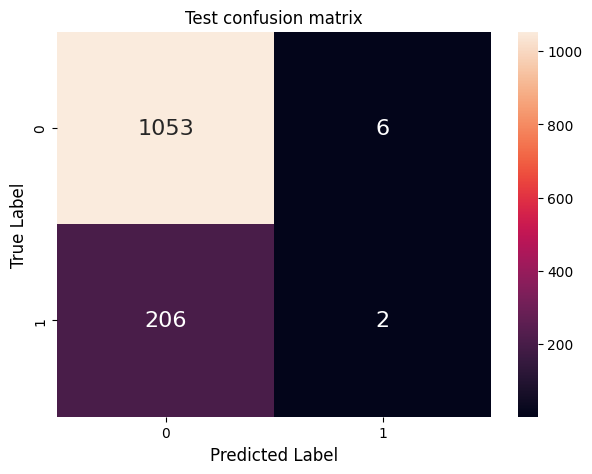

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions_rf))

# Confusion Matrix
cv_cf = confusion_matrix(y_test,predictions_rf)
plt.figure(figsize=(7,5))
sns.heatmap(cv_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.title('Test confusion matrix')
plt.show()

Naive Baye's

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1059
           1       0.00      0.00      0.00       208

    accuracy                           0.84      1267
   macro avg       0.42      0.50      0.46      1267
weighted avg       0.70      0.84      0.76      1267



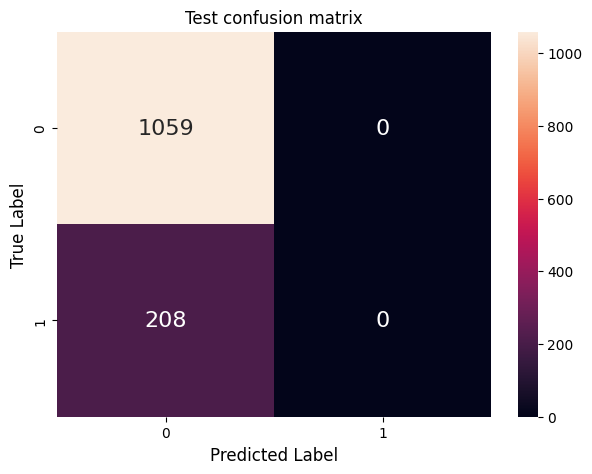

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions_nb))

# Confusion Matrix
cv_cf = confusion_matrix(y_test,predictions_nb)
plt.figure(figsize=(7,5))
sns.heatmap(cv_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.title('Test confusion matrix')
plt.show()

Logistic Regression

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1059
           1       0.00      0.00      0.00       208

    accuracy                           0.83      1267
   macro avg       0.42      0.50      0.45      1267
weighted avg       0.70      0.83      0.76      1267



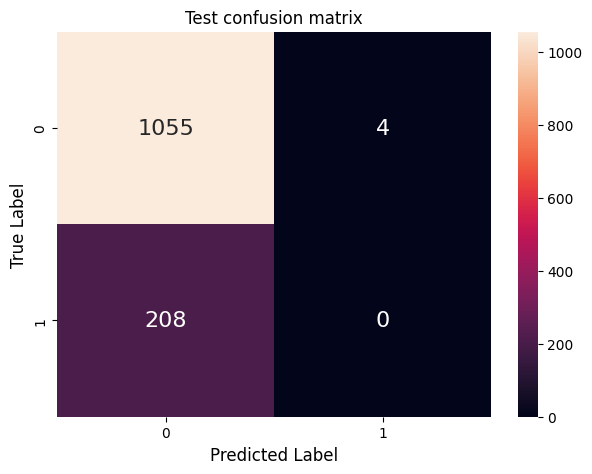

In [ ]:
print(classification_report(y_test, predictions_logReg))

# Confusion Matrix
cv_cf = confusion_matrix(y_test,predictions_logReg)
plt.figure(figsize=(7,5))
sns.heatmap(cv_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.title('Test confusion matrix')
plt.show()

XG Boost

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1059
           1       0.28      0.02      0.04       208

    accuracy                           0.83      1267
   macro avg       0.56      0.51      0.48      1267
weighted avg       0.75      0.83      0.76      1267



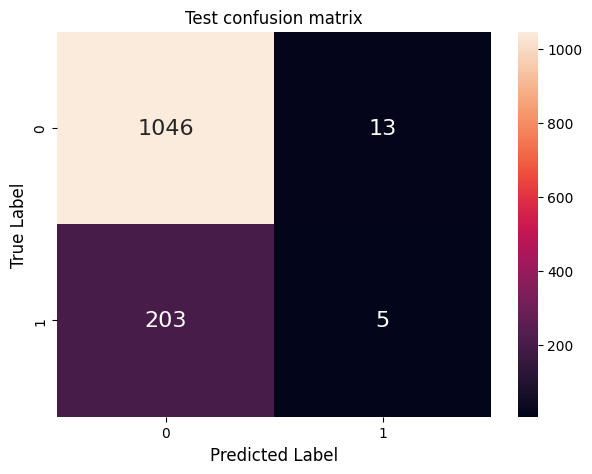

In [ ]:
print(classification_report(y_test, predictions_xgb))

# Confusion Matrix
cv_cf = confusion_matrix(y_test,predictions_xgb)
plt.figure(figsize=(7,5))
sns.heatmap(cv_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.title('Test confusion matrix')
plt.show()

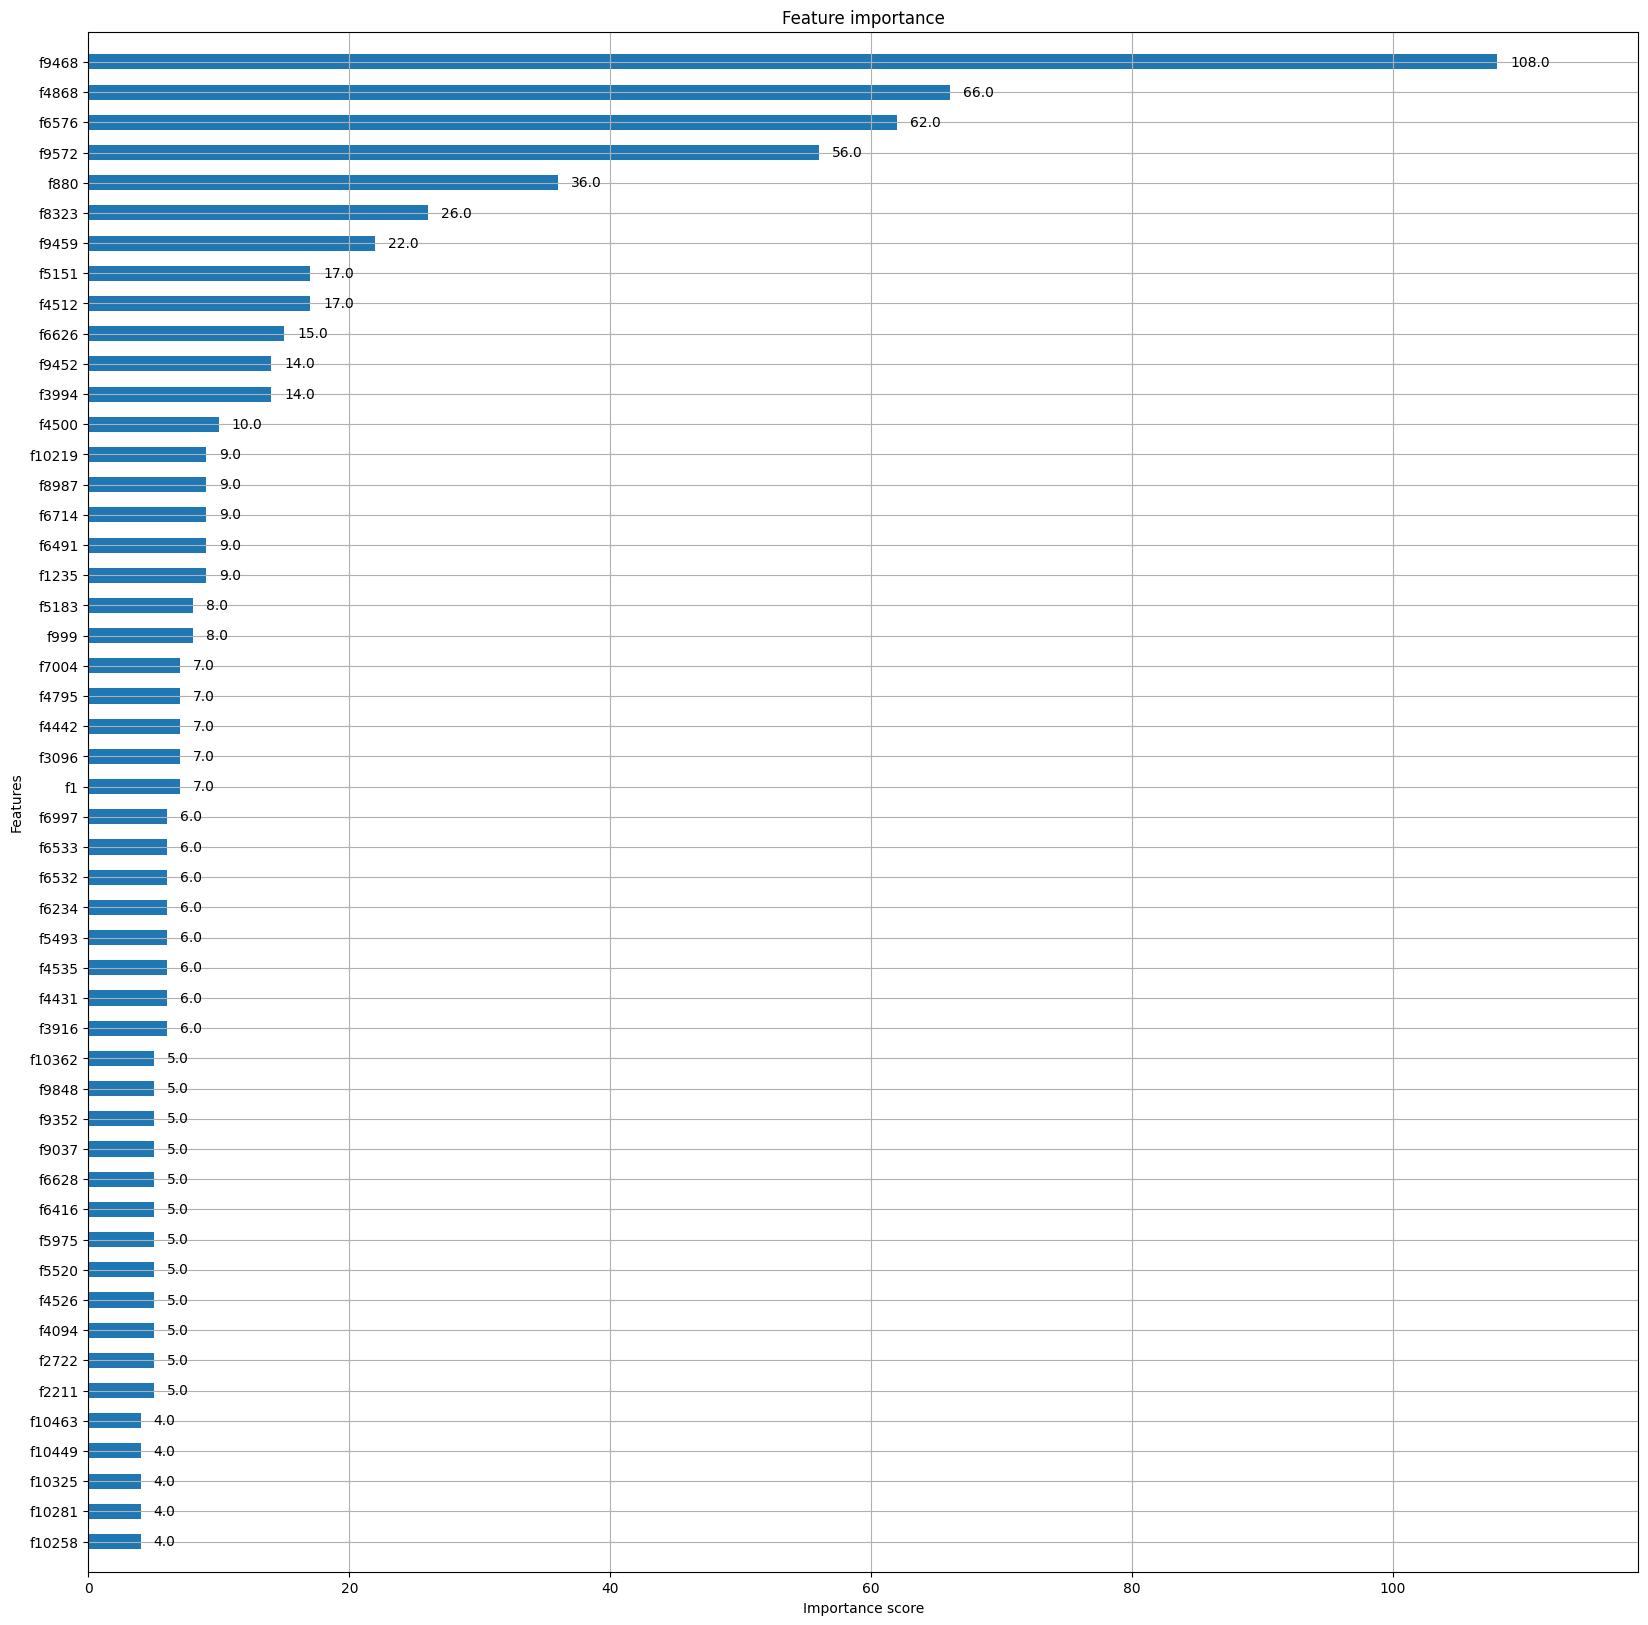

In [ ]:
from xgboost import plot_importance
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,20))
# Access the XGBoost model from the pipeline
xgb_model = xgb_pipeline_cv.named_steps['xgb_model']

booster = xgb_model.get_booster()  # get_booster() returns a Booster instance
plot_importance(xgb_model,max_num_features=50,height=0.5,ax=axes)
plt.show()